# FEIS Dataset - Transduction

## Load Dataset

In [1]:
from lib import FEISDataset

# Participant
pt       = "01\\"

# EEG Path
root_dir = "C:\\Users\\win8t\\OneDrive\\Desktop\\scottwellington-FEIS-7e726fd\\experiments\\"
root_dir += pt
csv_path = root_dir + "speaking.csv"

# Audio Path
audio_dir  = "C:\\Users\\win8t\\OneDrive\\Desktop\\scottwellington-FEIS-7e726fd\\wavs\\"
audio_dir  += pt
audio_dir  += "combined_wavs\\"

dataset = FEISDataset(csv_path=csv_path, audio_dir=audio_dir)

In [2]:
dataset[1]

{'label': 'thought',
 'audio_raw': array([-1.18135571e-07,  1.37116510e-07, -1.53045668e-07, ...,
        -5.22476139e-05, -8.66369722e-05, -9.18524788e-05]),
 'audio_features': array([[-11.507127 , -11.511995 , -11.5107355, ..., -11.512397 ,
         -11.512465 , -11.512809 ],
        [-11.498464 , -11.51079  , -11.51047  , ..., -11.512686 ,
         -11.512847 , -11.512906 ],
        [-11.50678  , -11.5046015, -11.473621 , ..., -11.512384 ,
         -11.512586 , -11.512898 ],
        ...,
        [-11.504572 , -11.5060215, -11.465543 , ..., -11.512306 ,
         -11.512681 , -11.512906 ],
        [-11.496264 , -11.507698 , -11.502245 , ..., -11.511716 ,
         -11.511783 , -11.512874 ],
        [-11.50264  , -11.510341 , -11.5056305, ..., -11.5126915,
         -11.512657 , -11.512883 ]], dtype=float32),
 'eeg_raw': array([[ -14.00675962,  -66.24688328,  -96.95513136, ...,  -95.53511705,
          -69.42218613,  -18.88626144],
        [ -14.41327722,  -67.67982728, -104.67739531, ..

## Data Visualisation

### Raw EEG (Drift Removed)

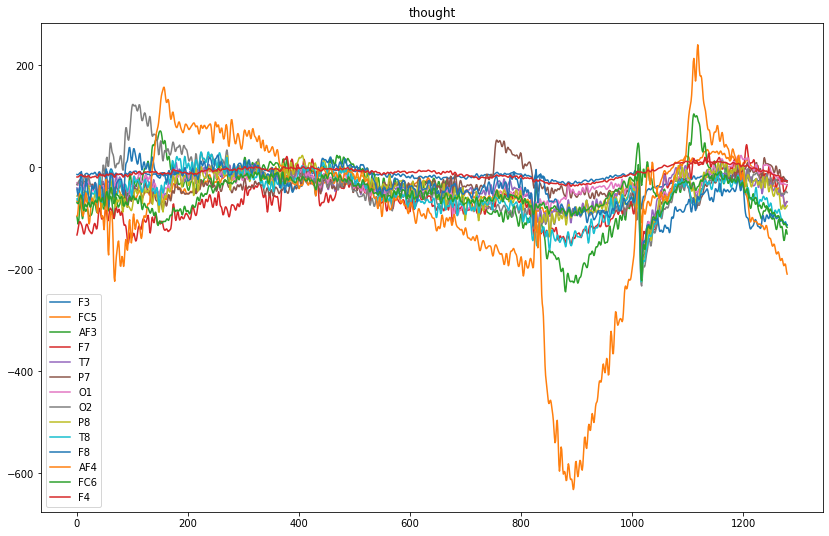

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 9)

example_idx = 1

eeg_data = dataset[example_idx]["eeg_raw"]
plt.title(dataset[example_idx]["label"])
for i in range(eeg_data.shape[1]):
    cur_channel = eeg_data[:, i]
    ch_name = dataset.channels[i]
    plt.plot(cur_channel, label=ch_name)
plt.legend()

### EEG Features (Digital Voicing)

eeg_feats.shape: (425, 70)


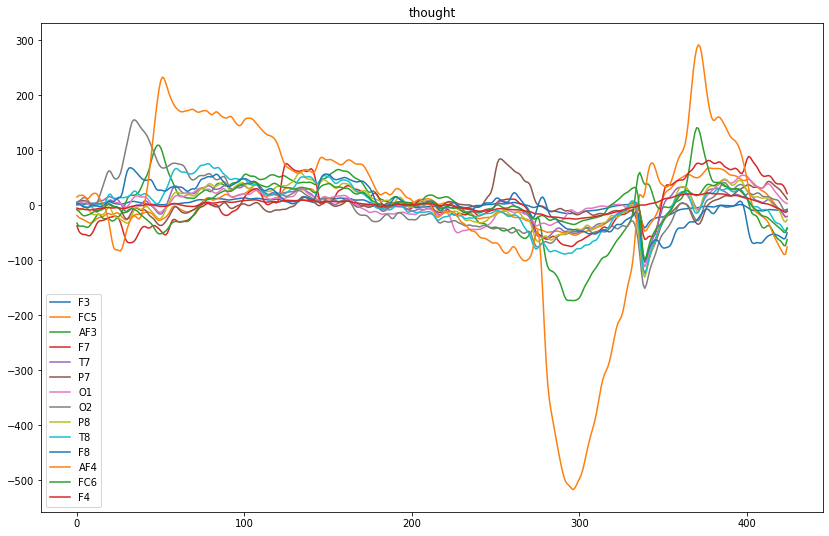

In [21]:
eeg_data = dataset[example_idx]["eeg_feats"]
plt.title(dataset[example_idx]["label"])
print("eeg_feats.shape:", eeg_data.shape)
for i in range(len(dataset.channels)):
    cur_channel = eeg_data[:, (i*5)+0]
    ch_name = dataset.channels[i]
    plt.plot(cur_channel, label=ch_name)
plt.legend()

### Audio

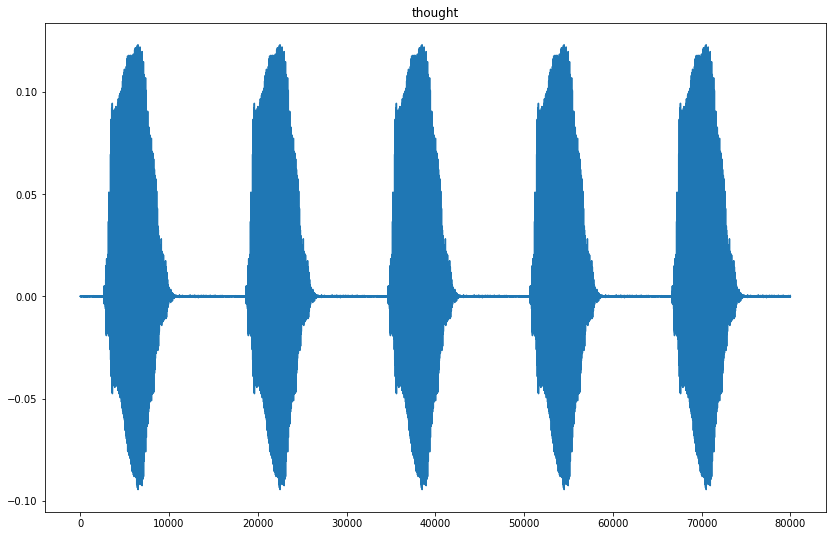

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 9)
plt.title(dataset[example_idx]["label"])
plt.plot(dataset[example_idx]["audio_raw"])